# 4. Let's get visual

In the previous parts we have built up our intuition (and hopefully also understanding) of how we can automatically learn to see patterns in our data and use them to predict behaviour on hiterto unseen data.

We have learnt the concept of Artificial Neural Networks.

As it turns out, this concept is very powerful!

### Universal Approximation Theorem

In the mathematical theory of artificial neural networks, the universal approximation theorem states that a feed-forward network with a single hidden layer containing a finite number of neurons can approximate continuous functions on compact subsets of Rn, under mild assumptions on the activation function. The theorem thus states that simple neural networks can represent a wide variety of interesting functions when given appropriate parameters.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Universal_approximation_theorem)

In other words, ANNs are powerful tools for approximating a wide variety of functions.

Let's use them to recognize hand-written digits.

But first some initialization.

In [1]:
# Initialization stuff
!gdown https://drive.google.com/uc?id=1LJccUzmjbD_tJ5TF3J3CkkeDNeItElLd
!unzip cgML.zip

%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable 
from scripts.helper import *
plt.style.use('ggplot')
# For reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# if it does not exist, download mnist dataset
root = "datasets"
train_set = datasets.MNIST(root=root, train=True, transform=None, download=True)
# We keep a copy of the dataset as is for visualization purposes
train_set_viz = datasets.MNIST(root=root, train=True, transform=None, download=True)
test_set = datasets.MNIST(root=root, train=False, transform=None, download=True)
# We keep a copy of the dataset as is for visualization purposes
test_set_viz = datasets.MNIST(root=root, train=False, transform=None, download=True)

Downloading...
From: https://drive.google.com/uc?id=1LJccUzmjbD_tJ5TF3J3CkkeDNeItElLd
To: /content/cgML.zip
35.4MB [00:00, 112MB/s] 
Archive:  cgML.zip
replace scripts/helper.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: scripts/helper.py       
  inflating: scripts/__pycache__/helper.cpython-37.pyc  
  inflating: .ipynb_checkpoints/1 - Facial Landmarks-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/1- Introduction - What is Machine Learning anyway_-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/2 - Automatic Learning-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/3 - A little inspiration from our brain-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/4 - Let's get visual!-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/5 - It ain't convoluted!-checkpoint.ipynb  
  inflating: .ipynb_checkpoints/6 - Putting it all together-checkpoint.ipynb  
  inflating: datasets/MNIST/processed/test.pt  
  inflating: datasets/MNIST/processed/training.pt  
  inflating: datase

### The MNIST dataset

The MNIST dataset probably constitutes the **_Hello world_** of Machine Learning.

It is a set of images of hand-written digits.

This is not a toy dataset. Let's see how many images it contains:

In [2]:
print("MNIST training set data contains {} images".format(len(train_set)))
print("MNIST test set data contains {} images".format(len(test_set)))

MNIST training set data contains 60000 images
MNIST test set data contains 10000 images


So far we have been dealing with training data that fits in the memory.

Each iteration in our training loop performed **_gradient descent_** on the **_cost function_** that was defined over the entire dataset.

With so much more data, that would be very slow.

Thus we need to performing training iterations on a subset of the data.

We call this subset a **_batch_** of data. We decide on a **_batch size_** and the cost is computed over each batch in our training loop.

As opposed to **_gradient descent_** performed over the entire training data, this **_batch_** based strategy is called **_stochastic gradient descent_**.

The iteration over all the batches in the training data is called the completion of an **_epoch_**.

While the size of each batch is fixed, it is common practice to shuffle the data at the completion of an **_epoch_**. This results in differnt data points in each batch every epoch i.e batch 0 in epoch 0 will be different from batch 0 in epoch 1.

We will use all the concepts we just covered, but first let's examine some images from the MNIST dataset.

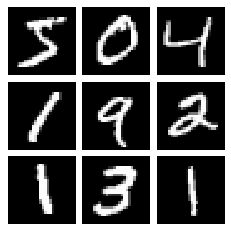

In [3]:
# Let's look at 9 images
im_list = [train_set[i][0] for i in range(9)]
thumb_grid(im_list, (3, 3))

In [4]:
# What's the size of each image?
im_list[0].size

(28, 28)

#### Images as data

How do we treat these images as data?

Each image is 28x28 pixels. Thus we could treat each image as an input of size 28x28.

In [5]:
# Treat image as data
np.array(im_list[0]).reshape((1, 28*28))

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
        126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,  30,  36

Fantastic! We can now use our knowledge from the previous sections to create an ANN.

In [0]:
# Input consist of size 28x28 
# First hidden layer of 500 units
# Second hidden layer 256 units
# Finally the output is 10 units each unit representing a digit
n_in, n_h1, n_h2, n_out = 28*28, 500, 256, 10

# This will flatten the input
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

# Here we will use the Sequential model api for a cleaner implementation
model = torch.nn.Sequential(Flatten(),
                            torch.nn.Linear(n_in, n_h1),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_h1, n_h2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_h2, n_out))

This is a pretty big model! Let's see how many weights we will be learning:

In [7]:
print("Number of parameters (weights + bias terms) we will learn: {}".format(trainable_parameters(model)))

Number of parameters (weights + bias terms) we will learn: 523326


We will be learning the values of more than half a million parameters!

Pytorch provides us with a convenient method of getting batches of data through **_DataLoaders_**.

Let's define our data loaders:

In [8]:
batch_size = 100

# We want to transform each image to a tensor and perform some normalization
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set.transform = trans
test_set.transform = trans

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print("The number of batches in one epoch over the training set is {}".format(len(train_loader)))
print("The number of batches in one epoch over the test set is {}".format(len(test_loader)))

# Let's see the help for the Normalize function
?transforms.Normalize

The number of batches in one epoch over the training set is 600
The number of batches in one epoch over the test set is 100


We can see that the numbers shown above make sense. After all, we had 60,000 images in the training set. We have set our **_batch size_** to 100. Therefore, we should have 600 batches per **_epoch_**.

We added some transforms to our datasets. Let's look at what we get as input data now:

In [9]:
train_set[0][0]

tensor([[[-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
          -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
          -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
          -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
          -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
          -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
          -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
          -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
          -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
          -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
          -0.5000, -0.5000, -0.5000, -0.5000, -0

We are effectively normalizing the data to have a mean of 0.5 and a standard deviation of 1. Another common technique that is often used is subtracting 127.5 from each pixel value and then dividing by 255.

Let's look at the shape of the item

In [10]:
train_set[0][0].shape

torch.Size([1, 28, 28])

### Cross entropy loss

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.

Since our output is 10 nodes each giving the probability of a digit, this measure for our loss function makes sense.

We'll use it:

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(10):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        #if use_cuda:
        #    x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        # Use an exponentially weighted average for running loss value
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))

==>>> epoch: 0, batch index: 100, train loss: 0.939570
==>>> epoch: 0, batch index: 200, train loss: 0.457600
==>>> epoch: 0, batch index: 300, train loss: 0.372079
==>>> epoch: 0, batch index: 400, train loss: 0.398162
==>>> epoch: 0, batch index: 500, train loss: 0.322596
==>>> epoch: 0, batch index: 600, train loss: 0.309751
==>>> epoch: 1, batch index: 100, train loss: 0.284283
==>>> epoch: 1, batch index: 200, train loss: 0.260029
==>>> epoch: 1, batch index: 300, train loss: 0.273299
==>>> epoch: 1, batch index: 400, train loss: 0.241561
==>>> epoch: 1, batch index: 500, train loss: 0.230588
==>>> epoch: 1, batch index: 600, train loss: 0.220963
==>>> epoch: 2, batch index: 100, train loss: 0.216370
==>>> epoch: 2, batch index: 200, train loss: 0.168218
==>>> epoch: 2, batch index: 300, train loss: 0.181308
==>>> epoch: 2, batch index: 400, train loss: 0.155947
==>>> epoch: 2, batch index: 500, train loss: 0.155363
==>>> epoch: 2, batch index: 600, train loss: 0.138144
==>>> epoc

[[5 0 4]
 [1 9 2]
 [1 3 1]]


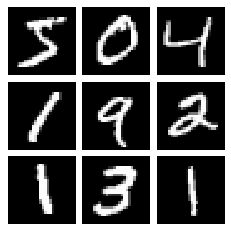

In [12]:
# Let's try our model on the first 9 rows of our training data
im_list = [train_set_viz[i][0] for i in range(9)]
thumb_grid(im_list, (3, 3))

y_hat = []
for i in range(9):
    X = Variable(train_set[i][0])
    y_hat.append(np.argmax(model(X).detach().numpy()))
print(np.array(y_hat).reshape((3,3)))
    

Great! We now know that our model has learn't something.

Let us now evaluate the model's accuracy on the validation data.

In [13]:
num_correct = 0
num_wrong = 0
for i in range(len(test_set)):
    X = Variable(test_set[i][0])
    y_hat = np.argmax(model(X).detach().numpy())
    if y_hat == test_set[i][1]:
        num_correct += 1
    else:
        num_wrong += 1
accuracy = num_correct / (num_correct + num_wrong)
print("Model accuracy on test data is {}".format(accuracy))

Model accuracy on test data is 0.9764


Fantastic! We have trained a model that can recognize hand-written digits with 97.49% accuracy.

## What just happened?

1. We started off by looking at images as data.
2. We examined the MNIST dataset and saw that it's a large dataset with 60,000 training images
3. We understood the concepts of **_batch size_**, **_epochs_**, and **_mini-batch_** based learning
4. We understood how **_gradient descent_** can be modified to work with  **_mini-batches_** to form the **_stochastic gradient descent_** algorithm.
5. We looked at the **_DataLoader_** class from Pytorch for supplying us with **_mini-batches_** while shuffling the data every **_epoch_**
6. We used our knowledge from the previous sections to define an **_ANN_** (also called a **_Multi-layer Perceptron_** or **_MLP_**) with 500 and 256 neurons in the hidden layers.
7. We observed that we are learning more that half a million parameters.
8. We trained our **_MLP_** on the training data.
9. We evaluated our model's accuracy on the test data.
10. We observed that we could achieve a 97.49% accuracy on unseen test data in just 10 training epochs.

## Can we do better?

Treating image pixels as input "**_features_**" results in a lot of weights! Can we make our models smaller?

In the next section, we will look at a new kind of network called a **_Convolutional Neural Network_**.